# CART-POLE GYM ENVIRONMENT

Our aim is to devise RL algorithms to try and solve the "Cart-Pole" environment provided in the Open-AI gym. In this environment, a pole is attached to a cart which can move left or right. Our goal is to apply forces to the cart so as to keep it upright. An episode runs a maximum for 500 time-steps, hence if the pole stays upright for 500 time-steps, the episode is considered solved. The reward for each time-step is 1.

The action space for this environment is a ndarray with shape (1,) which can take values {0,1} indicating the direction of the fixed force the cart is pushed with. The observation space is a ndarray with shape (4,) which contains the following values:
| Num | Observation | Min | Max |
|-----------------|-----------------| -----|-----|
| 0  | Cart Position  | -4.8 | 4.8 |
| 1  | Cart Velocity  | -Inf | Inf |
| 2  | Pole Angle     | -24 deg | 24 deg |
| 3  | Pole Angular Velocity  | -Inf | Inf |

Also, the episode terminates if the cart position leaves the range [-2.4, 2.4] or the pole angle leaves the range [-12 deg, 12 deg] and the pole angle is returned in radians.

Now, the State Space is continous, hence we cannot just use a lookup table to store our Q-values. There are two ways we can counter this, one is we use a function approximator with some parameters to approximate our Q-values. Another way is to discretise the state space, as to break it into a discrete space rather than being continous. 

To discretize the state space we will split each observation into some n equal parts and assign each interval to its lower bound. Now for obs number 0 and 2 we can discretize in a way that if the values are outside their non terminal range, we just put all of those into one interval rather than splitting them but as of now we aren't doing that, maybe we'll try later to see if it optimises our space much. (As in our original implementation a lot of the states won't ever be reached as the episode terminates before reaching them). For observation 1 and 3, they go from -INF to +INF, hence we can't just split it into some n intervals and get a finite state space. For that what we did was we ran the environment many times by hand to get an idea of the range of values the velocity and angular velocity stay in before the episode terminates because the velocity or angular velocity we just to large enough to be able to correct. 

Using this code, we did some experimentation.

In [ ]:
import gymnasium as gym

env = gym.make("CartPole-v1" , render_mode="rgb_array")
env.reset()
while True:
    action = int(input("Action: "))
    if action in (0, 1):
        x = env.step(action)
        print(f"v:{x[0][1]} , w:{x[0][3]}")
        env.render()

From this we got to the conclusion that velocity takes values between -4 and 4 and angular velocity stays between -4 and 4 at max. Also if the values go outside this interval, we equate them to these bounds.

Doing some pretty basic mathematics we see that we can implementing this by mapping our observation x to $$round(\frac{x-a}{b-a} \times n)$$ where n is the "granularity constant" and a and b are the lower and upper bounds of x respectively.

Now coming to the RL algorithm to be used, we see all episodes are guaranteed to be terminated, hence we can use any either forward view or backward view algorithm. Here we'll be implementing backward view SARSA($\lambda$) with Eligibility Traces.

First we import the required modules we'll be using.

In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

Now we'll define some constants which we'll be using throughout such as learning rate, discount factor etc.

In [10]:
granularity_0 = 8
granularity_1 = 8
granularity_2 = 32
granularity_3 = 16

EPSILON_INIT = 1
EPSILON_DECAY = 0.9994
EPSILON_MIN = 0.05
EPSILON = EPSILON_INIT

DISCOUNT_FACTOR = 0.9

LEARNING_RATE = 0.9
LEARNING_RATE_DECAY = 0.99999

LAMBDA = 0.4

Also initialise some other variables and our q tables

In [17]:
Q = np.zeros(( granularity_0 , granularity_1 , granularity_2 , granularity_3  , 2))
n = 30000
mean_width = 100
reward_list = np.zeros(n+1)
average_reward_list = np.zeros(n+1)
mean_reward_list = np.zeros(n-mean_width+1)
ep_count = 0

In [18]:
def choose_action(state):
    global EPSILON
    EPSILON = max(EPSILON_MIN , EPSILON * EPSILON_DECAY)
    if(np.random.random() < EPSILON):
        return int(env.action_space.sample())
    else:
        return np.argmax(Q[int(state[0]) , int(state[1]), int(state[2]) , int(state[3]) , :])


In [124]:
def discretize_state(state):
    state[0] = int(((state[0] + 4.8) / (9.6)) * granularity_0 )
    if(state[0] >= granularity_0):
        state[0] = granularity_0 - 1
    state[1] = int(((state[1] + 4.0) / (8.0)) * granularity_1 )
    if(state[1] >= granularity_1):
        state[1] = granularity_1 - 1
    state[2] = int(((state[2] + 0.42) / (0.84)) * granularity_2 )
    if(state[2] >= granularity_2):
        state[2] = granularity_2 - 1
    state[3] = int(((state[3] + 4.0) / (8.0)) * granularity_3 )
    if(state[3] >= granularity_3):
        state[3] = granularity_3 - 1
    return (state)

The choose_action function implements our epsilon-greedy algorithm and the discretize_states function discretizes our state space based on the corresponding granularity constant.

In [20]:
env = gym.make("CartPole-v1" , render_mode="rgb_array")

while(n):
    n -= 1
    ep_count += 1
    E = np.zeros(( granularity_0 , granularity_1 , granularity_2 , granularity_3  , 2))
    state_prev = env.reset()[0]
    state_prev = discretize_state(state_prev)
    action_prev = env.action_space.sample()
    total_reward = 0
    while(True):
        state, reward, done, truncated, info = env.step(action_prev)
        total_reward += reward
        state = discretize_state(state)
        action = choose_action(state)
        Td_error = reward + (DISCOUNT_FACTOR * Q[int(state[0]) , int(state[1]), int(state[2]) , int(state[3]) , action]) - Q[int(state_prev[0]) , int(state_prev[1]), int(state_prev[2]) , int(state_prev[3]) , action_prev]
        E[int(state_prev[0]) , int(state_prev[1]), int(state_prev[2]) , int(state_prev[3]) , action_prev] += 1
        Q += LEARNING_RATE * Td_error * E
        E *= (DISCOUNT_FACTOR * LAMBDA)
        state_prev = state
        action_prev = action
        if done:
            break
    # LEARNING_RATE = max(0.1 , LEARNING_RATE * LEARNING_RATE_DECAY)
    reward_list[ep_count] = total_reward
    average_reward_list[ep_count] = reward_list[:ep_count].mean()
    if ep_count > mean_width:
        mean_reward_list[ep_count-mean_width] = reward_list[ep_count-mean_width:ep_count].mean()
    print(f"total_reward : {total_reward} , episode : {ep_count}")

total_reward : 11.0 , episode : 1
total_reward : 17.0 , episode : 2
total_reward : 32.0 , episode : 3
total_reward : 29.0 , episode : 4
total_reward : 15.0 , episode : 5
total_reward : 25.0 , episode : 6
total_reward : 24.0 , episode : 7
total_reward : 17.0 , episode : 8
total_reward : 14.0 , episode : 9
total_reward : 28.0 , episode : 10
total_reward : 16.0 , episode : 11
total_reward : 31.0 , episode : 12
total_reward : 16.0 , episode : 13
total_reward : 12.0 , episode : 14
total_reward : 22.0 , episode : 15
total_reward : 10.0 , episode : 16
total_reward : 20.0 , episode : 17
total_reward : 35.0 , episode : 18
total_reward : 36.0 , episode : 19
total_reward : 29.0 , episode : 20
total_reward : 11.0 , episode : 21
total_reward : 11.0 , episode : 22
total_reward : 29.0 , episode : 23
total_reward : 28.0 , episode : 24
total_reward : 19.0 , episode : 25
total_reward : 47.0 , episode : 26
total_reward : 12.0 , episode : 27
total_reward : 11.0 , episode : 28
total_reward : 16.0 , episode

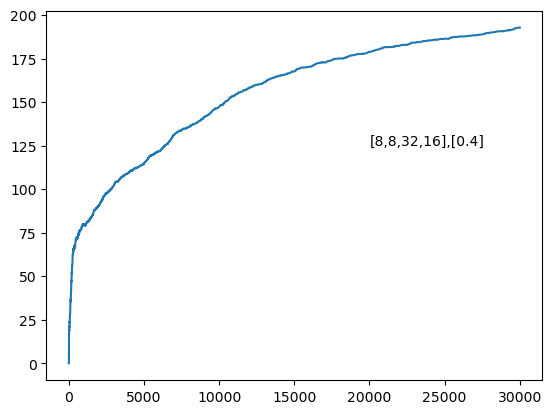

In [26]:
plt.plot(average_reward_list)
plt.text(20000,125,"[8,8,32,16],[0.4]")
plt.show()

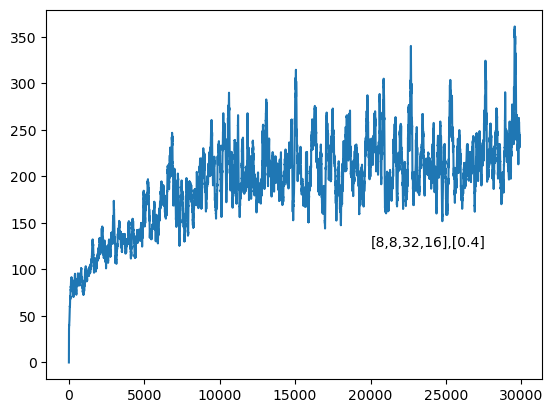

In [27]:
plt.plot(mean_reward_list)
plt.text(20000,125,"[8,8,32,16],[0.4]")
plt.show()

In [29]:
mean_reward_list2 = np.zeros(ep_count - 1000 + 1)
for i in range(1000,ep_count):
    mean_reward_list2[i-1000] = reward_list[i-1000:i].mean()

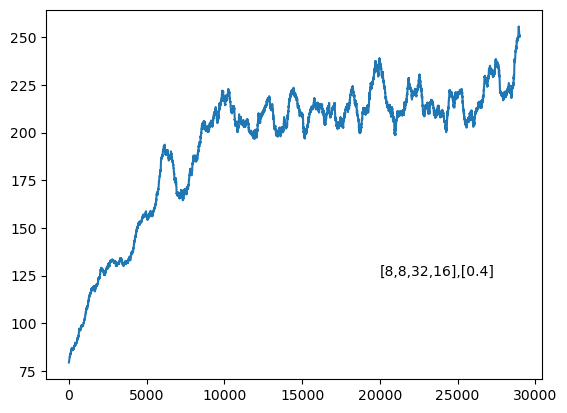

In [30]:
plt.plot(mean_reward_list2[:ep_count-1000])
plt.text(20000,125,"[8,8,32,16],[0.4]")
plt.show()

The first graph we have plotted is the average reward from episode 1 till n. The second graph is the mean reward of the last 100 episodes and the third graph plots the mean for the last 1000 episodess. Its pretty evident that around 12000-13000, the progress has stagnated and we're getting an average reward of around 200-220.

$\textbf{So now that our algorithm "works", let's try and tweak some of our hyperparameters and try to understand their significance and effects.}$

# So conclusion the best hyperparameters i found were [4,4,8,16] for granularity, Discount factor of 0.9, Learning rate with a decay of 0.999 and minimum 0.1 and lambda of 0.4

I Ran 100,000 episodes with these hyperparameters and this was the result.

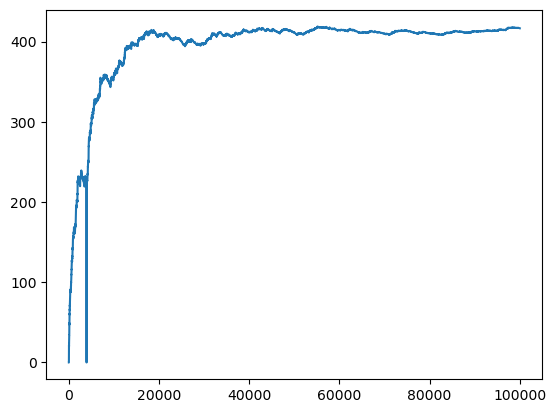

6048
416.47472


In [172]:
plt.plot(average_reward_list)
rlcopy = reward_list.copy()
plt.show()
count = 0
for i in reward_list[60000:]:
    if i >= 416:
        count += 1

print(count)
print(average_reward_list[-1])

# Hence our algorithm does solve the environment with an average reward of 416.5. After learning for 20k episodes it has learnt all that it can. Around 15% of the episodes it crosses the average reward.

First let's see how changing granularity constants affect our algorithm. Let's increase our granularity by 4 times making our state space finer and see what that does. As now we take up a lot more space and each episode will run slower let's also reduce the no. of episodes else it'll take too much time to end. Now we'll reuse the next blocks to get results.

In [130]:
granularity_0 = 4
granularity_1 = 4
granularity_2 = 8
granularity_3 = 16

EPSILON_INIT = 1
EPSILON_DECAY = 0.9994
EPSILON_MIN = 0.05
EPSILON = EPSILON_INIT

DISCOUNT_FACTOR = 0.9

LEARNING_RATE = 0.9
LEARNING_RATE_DECAY = 0.999

LAMBDA = 0.4

Q = np.zeros(( granularity_0 , granularity_1 , granularity_2 , granularity_3  , 2))
n = 100000
mean_width = 1000
reward_list = np.zeros(n+1)
average_reward_list = np.zeros(n+1)
mean_reward_list = np.zeros(n-mean_width+1)
ep_count = 0

In [132]:
import time
t = time.time()
while(n):
    n -= 1
    ep_count += 1
    E = np.zeros(( granularity_0 , granularity_1 , granularity_2 , granularity_3  , 2))
    state_prev = env.reset()[0]
    state_prev = discretize_state(state_prev)
    action_prev = env.action_space.sample()
    total_reward = 0
    while(True):
        state, reward, done, truncated, info = env.step(action_prev)
        total_reward += reward
        state = discretize_state(state)
        action = choose_action(state)
        Td_error = reward + (DISCOUNT_FACTOR * Q[int(state[0]) , int(state[1]), int(state[2]) , int(state[3]) , action]) - Q[int(state_prev[0]) , int(state_prev[1]), int(state_prev[2]) , int(state_prev[3]) , action_prev]
        E[int(state_prev[0]) , int(state_prev[1]), int(state_prev[2]) , int(state_prev[3]) , action_prev] += 1
        Q += LEARNING_RATE * Td_error * E
        E *= (DISCOUNT_FACTOR * LAMBDA)
        state_prev = state
        action_prev = action
        if done:
            break
    LEARNING_RATE = max(0.1 , LEARNING_RATE * LEARNING_RATE_DECAY)
    reward_list[ep_count] = total_reward
    average_reward_list[ep_count] = reward_list[:ep_count].mean()
    if ep_count > mean_width:
        mean_reward_list[ep_count-mean_width] = reward_list[ep_count-mean_width:ep_count].mean()
print(time.time() - t)
    # print(f"total_reward : {total_reward} , episode : {ep_count}")

1227.802700996399


Ran it for granularity [32,32,32,32] and it just takes too much time to run each episode without any significant increase in rewards early on compared to [8,8,32,16]. Let's try lower granularity of [5,5,8,5].

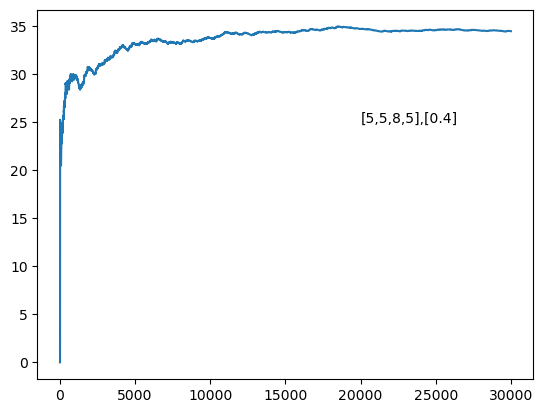

In [45]:
plt.plot(average_reward_list)
plt.text(20000,25,"[5,5,8,5],[0.4]")
plt.show()

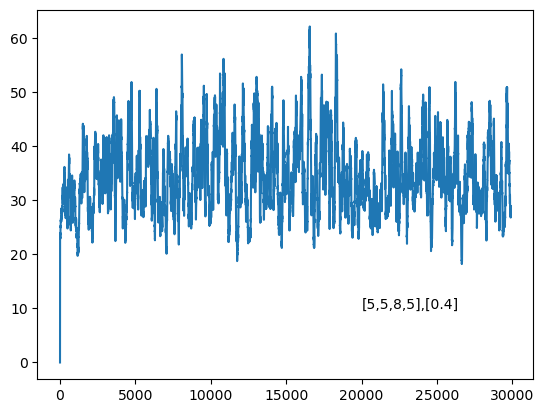

In [46]:
plt.plot(mean_reward_list)
plt.text(20000,10,"[5,5,8,5],[0.4]")
plt.show()

We see with [5,5,8,5] the algorithm converges around just 35 reward. The reason we think this might be because the state space is so coarse that its not able to capture enough detail of the observation space and hence within an interval the actions lead to the terminal state.

I think this is enough to get a good approximation of the granularity that is optimal.

Now let's try to see what lambda is best for our model. We know lambda = 0 corresponds to TD(0) learning and lambda = 1 corresponds to MC learning.

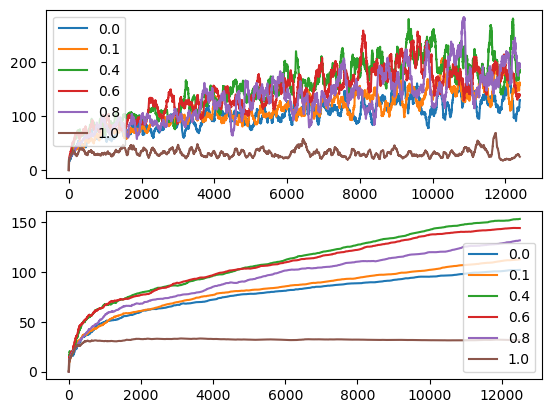

In [62]:
LAMBDA = [0.0,0.1,0.4,0.6,0.8,1.0]
for i in range(6):
    plt.subplot(2,1,1)
    plt.plot(ml[i] , label = f"{LAMBDA[i]}")
    plt.legend()
    plt.subplot(2,1,2)
    plt.plot(arl[i] , label = f"{LAMBDA[i]}")
    plt.legend()
plt.show()

/var/folders/lw/dkbr0lvx3rl5rqr6y040_bhh0000gn/T/ipykernel_90907/2097603073.py:4: RuntimeWarning: Mean of empty slice.
  mean_reward_list2[i-100] = ml[j][i-100:i].mean()


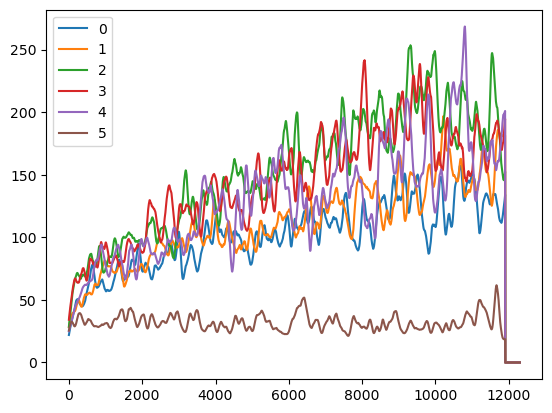

In [65]:
for j in range(6):
    mean_reward_list2 = np.zeros(12391)
    for i in range(10,12000):
        mean_reward_list2[i-100] = ml[j][i-100:i].mean()
    plt.plot(mean_reward_list2 , label = f"{j}")
    plt.legend()
plt.show()

## We can see that the optimal lambda is around 0.4 to 0.5. 

We could somewhat expect that lambda will be somewhat in between 0 and 1 because lambda = 0 means we are just looking one step behind but it could be that the agent took a series of bad steps which after some time lead to termination but we are not capturing them with lambdaa = 0 and with a high lambda we're giving too much importance to steps long back whereas the recent steps led to its downfall and the older steps didn't.

Now let's try different discount factors and see what happens.

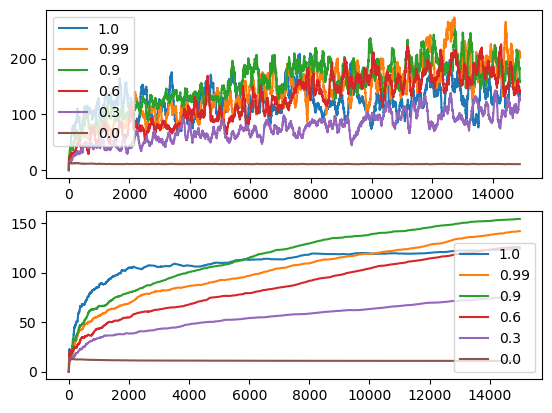

In [73]:
DS = [1.0,0.99,0.9,0.6,0.3,0.0]
for i in range(6):
    plt.subplot(2,1,1)
    plt.plot(ml[i] , label = f"{DS[i]}")
    plt.legend()
    plt.subplot(2,1,2)
    plt.plot(arl[i] , label = f"{DS[i]}")
    plt.legend()
plt.show()

### Here we can see discount factors 0.99 and 0.9 highly outperform the others.

Actually let's run 0.9, 0.95 and 0.99 for longer and see what happens.

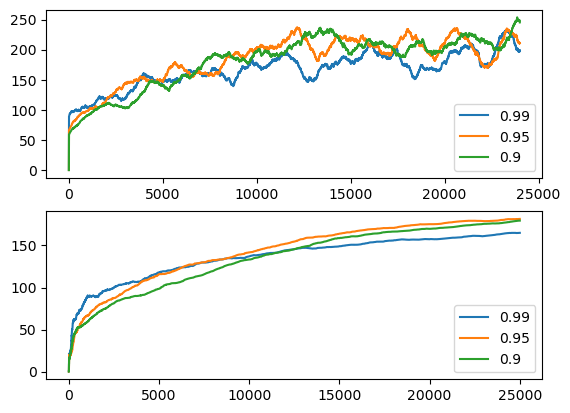

In [76]:
DS = [0.99,0.95,0.9]
for i in range(3):
    plt.subplot(2,1,1)
    plt.plot(ml[i] , label = f"{DS[i]}")
    plt.legend()
    plt.subplot(2,1,2)
    plt.plot(arl[i] , label = f"{DS[i]}")
    plt.legend()
plt.show()

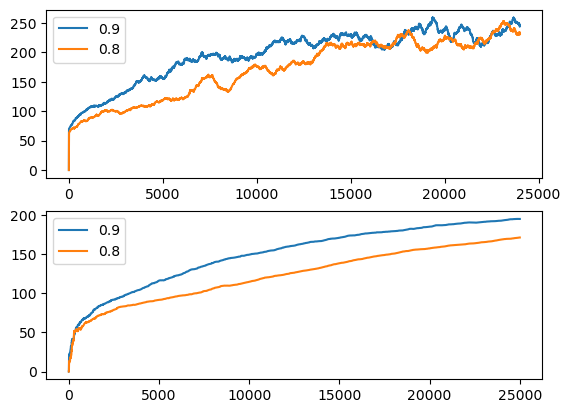

In [80]:
DS = [0.9,0.8]
for i in range(2):
    plt.subplot(2,1,1)
    plt.plot(ml[i] , label = f"{DS[i]}")
    plt.legend()
    plt.subplot(2,1,2)
    plt.plot(arl[i] , label = f"{DS[i]}")
    plt.legend()
plt.show()

### We can see 0.9 and 0.95 perform somewhat better compared to 0.99 and 0.8. So discount factor is optimal around 0.9-0.95

The 0.8 also reaches upto the rewards of the 0.9 but its significanly later.

#### Now let's see learning rate. We'll try some constant learning rates. We'll also try a decaying learning rate.

The decaying learning rate signifies that at first we don't have much idea of the correct q values so we wanna learn more from our present experience. But later we have a somewhat good estimate of the q values so we reduce the learning rate as we don't wanna adjust our estimates too much towards the error.

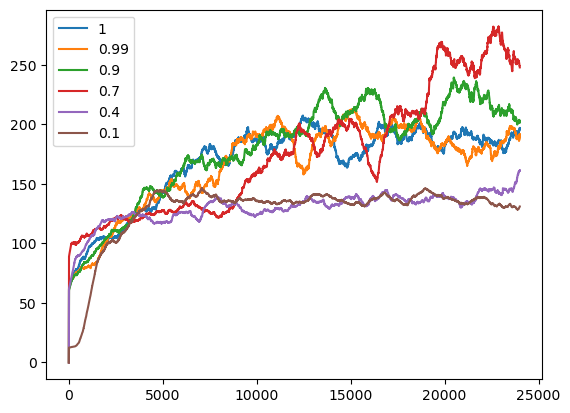

In [83]:
LR = [1,0.99,0.9,0.7,0.4,0.1]
for i in range(6):
    plt.plot(ml[i] , label = f"{LR[i]}")
    plt.legend()
plt.show()

In [ ]:
for i in range(6):
    plt.plot(arl[i] , label = f"{LR[i]}")
    plt.legend()
plt.show()

Learning Rates of 0.9 and 0.7 perform the best. The 0.7 has a wierd spike in mean reward and even the 0.9 has a slight spike. Let's try to run some more episodes in 0.9 anf 0.7 to see what happens

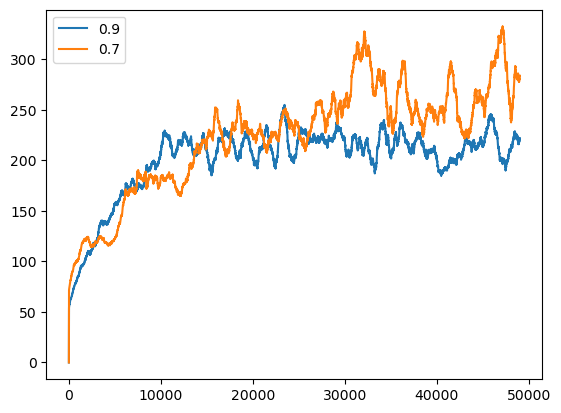

In [87]:
LR = [0.9,0.7]
for i in range(2):
    plt.plot(ml[i] , label = f"{LR[i]}")
    plt.legend()
plt.show()

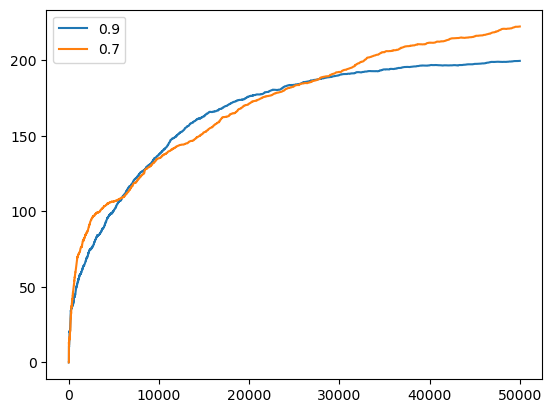

In [88]:
for i in range(2):
    plt.plot(arl[i] , label = f"{LR[i]}")
    plt.legend()
plt.show()

### So a thing to notice is that initially 0.9 had a faster increase but the converged but 0.7 is going on increasing and has crossed 0.9 in average reward and hasnt convincingly converged. It might even go higher. 

Now let's try a decaying learning rate and see if it performs any better.

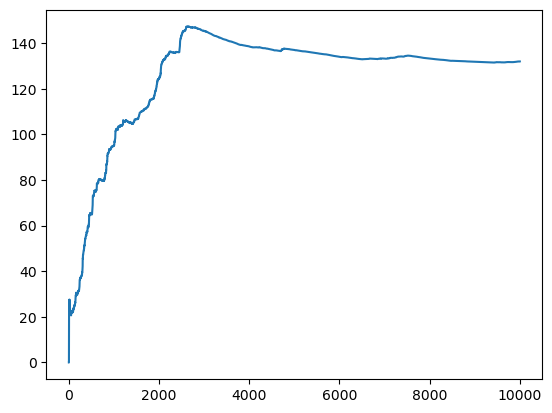

In [91]:
plt.plot(arl[0])
plt.show()

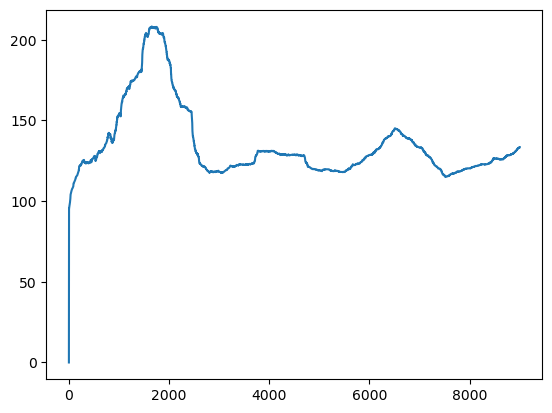

In [92]:
plt.plot(ml[0])
plt.show()

This was with initial LR = 0.99 and decay = 0.999 such that at episode x LR = 0.99 * (0.999)^x with a minimum limit of 0.1. WE can see that the performance just drops as the LR reaches its min too early. Let's try again.

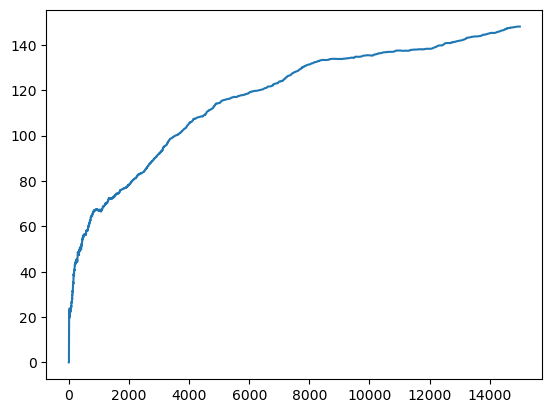

In [95]:
plt.plot(arl[0])
plt.show()

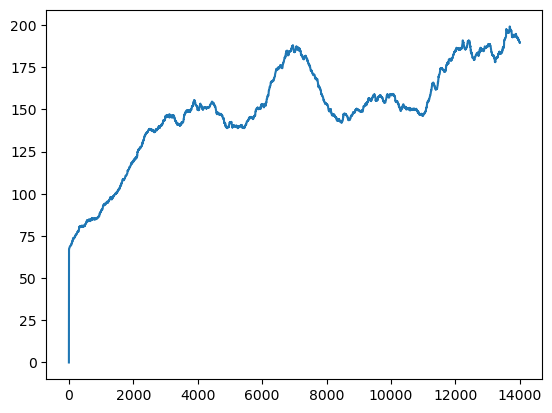

In [96]:
plt.plot(ml[0])
plt.show()

This looks promising lets run it for more episodes and compare it to constant LR=0.7

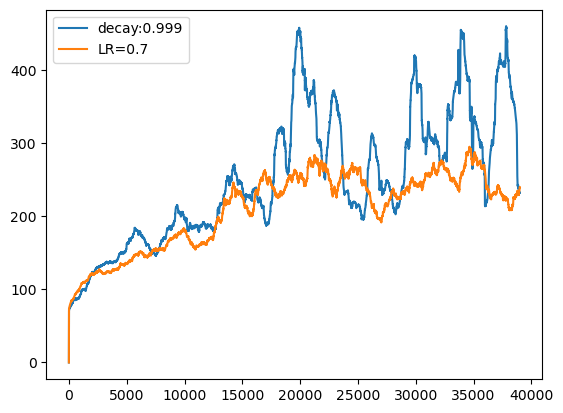

In [99]:
LR = ["decay:0.999","LR=0.7"]
for i in range(2):
    plt.plot(ml[i] , label = f"{LR[i]}")
    plt.legend()
plt.show()

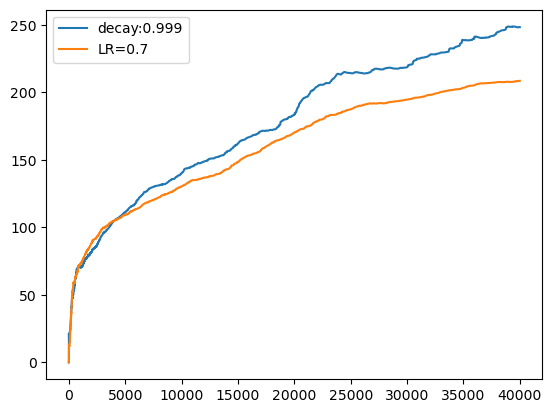

In [100]:
for i in range(2):
    plt.plot(arl[i] , label = f"{LR[i]}")
    plt.legend()
plt.show()

The decay agent is a little unstable but it far outperforms the constant learning rate methods.

Another thing to try is to slightly reduce the granularisation and see does it speed up the code execution without much loss in performance.

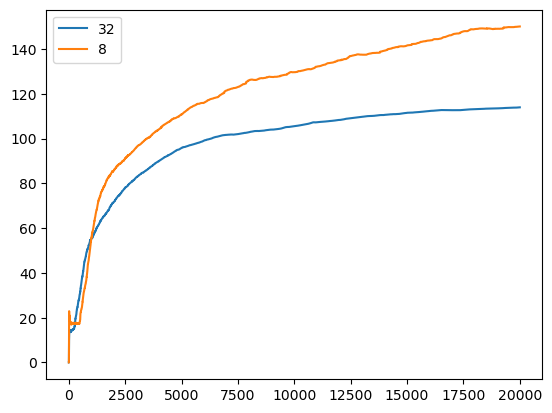

In [109]:
g = [32,8]
for i in range(2):
    plt.plot(arl[i] , label = f"{g[i]}")
    plt.legend()
plt.show()

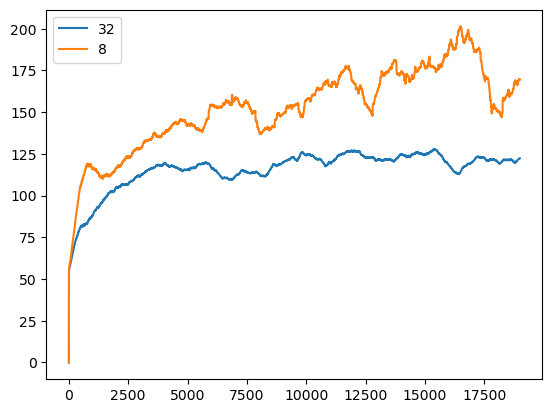

In [110]:
for i in range(2):
    plt.plot(ml[i] , label = f"{g[i]}")
    plt.legend()
plt.show()

So g_2 = 8 is better than 32. It takes half the time to run and gives better performance.

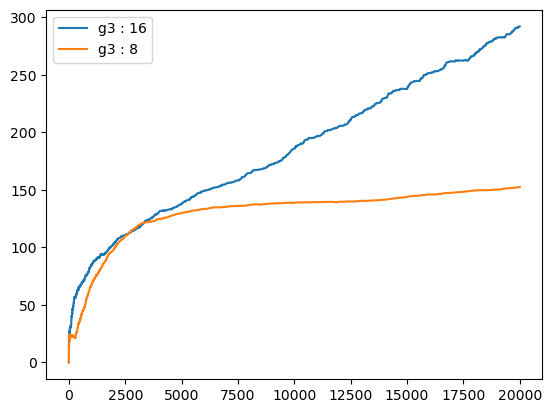

In [113]:
g = [16,8]
for i in range(2):
    plt.plot(arl[i] , label = f"g3 : {g[i]}")
    plt.legend()
plt.show()

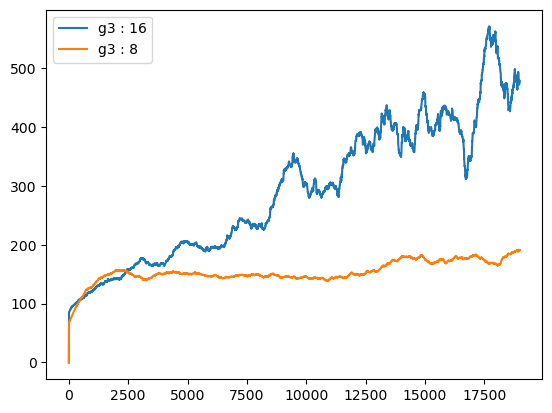

In [114]:
for i in range(2):
    plt.plot(ml[i] , label = f"g3 : {g[i]}")
    plt.legend()
plt.show()

g3 = 16 is better than g3 = 8.

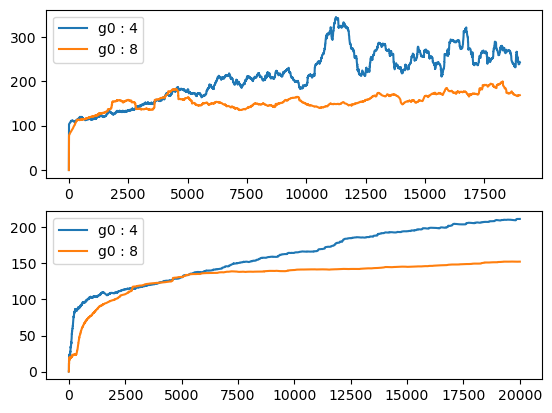

In [117]:
g = [4,8]
for i in range(2):
    plt.subplot(2,1,1)
    plt.plot(ml[i] , label = f"g0 : {g[i]}")
    plt.legend()
    plt.subplot(2,1,2)
    plt.plot(arl[i] , label = f"g0 : {g[i]}")
    plt.legend()
plt.show()

g0 = 4 is better.

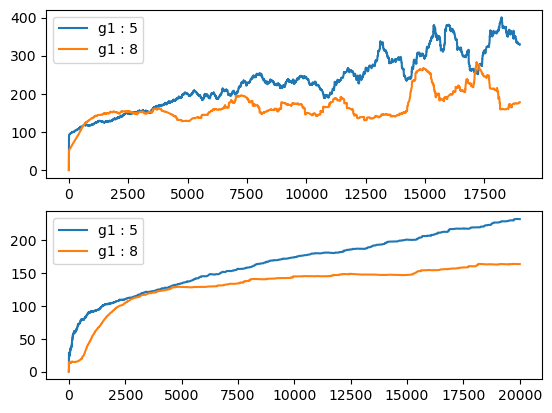

In [128]:
g = [5,8]
for i in range(2):
    plt.subplot(2,1,1)
    plt.plot(ml[i] , label = f"g1 : {g[i]}")
    plt.legend()
    plt.subplot(2,1,2)
    plt.plot(arl[i] , label = f"g1 : {g[i]}")
    plt.legend()
plt.show()

# So conclusion the best hyperparameters i found were [4,5,16,8] for granularity, Discount factor of 0.9, Learning rate with a decay of 0.999 and minimum 0.1 and lambda of 0.4

In [138]:
rr = []
for _ in range(200):
    sp = env.reset()[0]
    sp = discretize_state(sp)
    ap = np.argmax(Q[int(sp[0]) , int(sp[1]) , int(sp[2]) , int(sp[3]) , :])
    tr = 0
    while(True):
        s, r, d, t, i = env.step(ap)
        tr += r
        s = discretize_state(s)
        a = np.argmax(Q[int(s[0]) , int(s[1]), int(s[2]) , int(s[3]) , :])
        sp = s
        ap = a
        if d:
            break
    rr.append(tr)



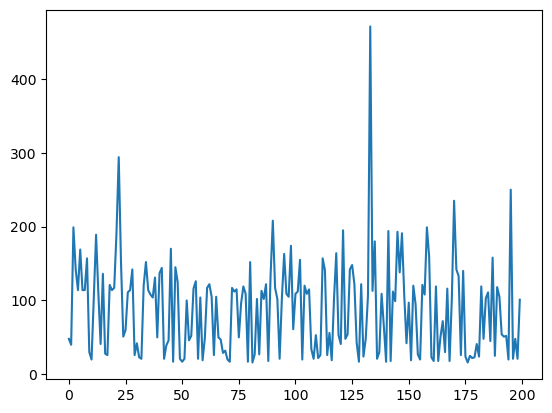

In [139]:
plt.plot(rr)
plt.show()


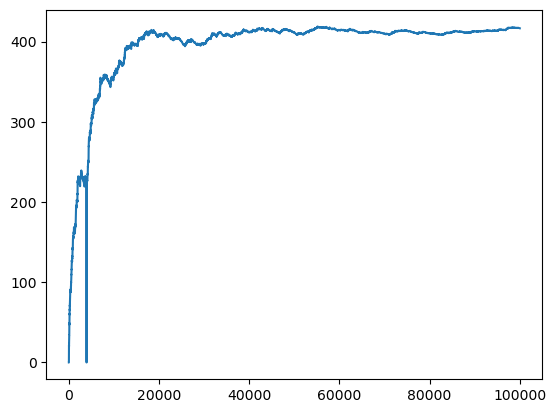

In [140]:
plt.plot(average_reward_list)
plt.show()

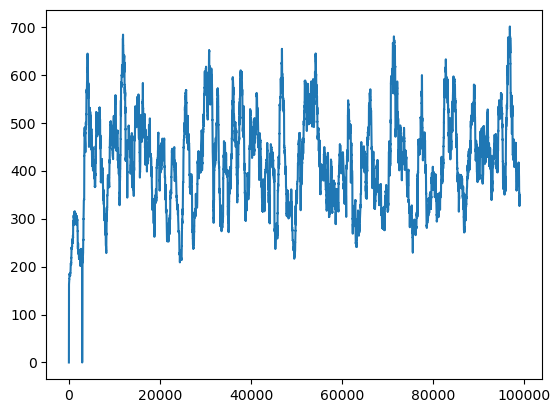

In [141]:
plt.plot(mean_reward_list)
plt.show()